#### Import libraries

In [ ]:
%pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from skopt.space import Integer, Real, Categorical

from skopt import BayesSearchCV

#### Load the dataset

In [ ]:
california_X, california_y = fetch_california_housing(return_X_y = True)
X = pd.DataFrame(california_X)
y = pd.Series(california_y)

X.head()

,0,1,2,3,4,5,6,7
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


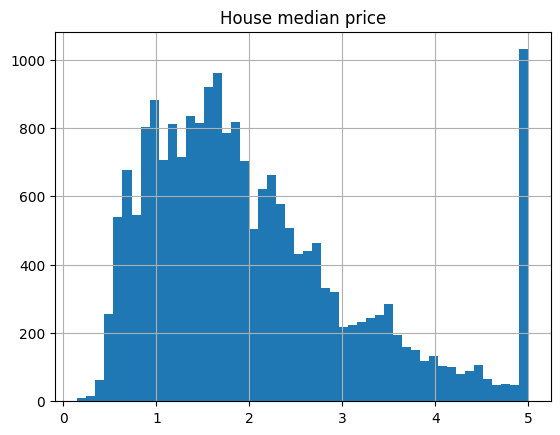

In [ ]:
y.hist(bins=50)
plt.title('House median price')
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
gbm = GradientBoostingRegressor(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': (10, 120),
    'min_samples_split': Real(0.01, 0.99, prior='log-uniform'),
    'max_depth': (1, 8),
    'loss': ['squared_error', 'absolute_error', 'huber']
}

#### Bayesian Optimization

In [ ]:
search = BayesSearchCV(
    estimator=gbm,
    search_spaces=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_iter=50,
    random_state=42,
    n_jobs=-1,
    refit=True
)

search.fit(X_train, y_train)

BayesSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
              n_jobs=-1, random_state=42, scoring='neg_mean_squared_error',
              search_spaces={'loss': ['squared_error', 'absolute_error',
                                      'huber'],
                             'max_depth': (1, 8),
                             'min_samples_split': Real(low=0.01, high=0.99, prior='log-uniform', transform='normalize'),
                             'n_estimators': (10, 120)})

In [ ]:
search.best_params_

OrderedDict([('loss', 'huber'),
             ('max_depth', 8),
             ('min_samples_split', 0.019706843265373128),
             ('n_estimators', 120)])

In [ ]:
search.best_score_

-0.23546672542037786

In [ ]:
results = pd.DataFrame(search.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_max_depth,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.424454,0.109966,0.013010,0.008338,absolute_error,6,0.727217,45,"{'loss': 'absolute_error', 'max_depth': 6, 'mi...",-0.497968,-0.506506,-0.507700,-0.504058,0.004334,48
1,10.707090,1.469664,0.025548,0.003270,huber,7,0.040318,115,"{'loss': 'huber', 'max_depth': 7, 'min_samples...",-0.245538,-0.242957,-0.252548,-0.247015,0.004052,18
2,4.942865,0.615318,0.017681,0.000404,absolute_error,7,0.016191,58,"{'loss': 'absolute_error', 'max_depth': 7, 'mi...",-0.271731,-0.271494,-0.280691,-0.274639,0.004281,33
3,3.934519,1.281781,0.011113,0.000776,huber,2,0.156129,98,"{'loss': 'huber', 'max_depth': 2, 'min_samples...",-0.343438,-0.342907,-0.362513,-0.349619,0.009120,41
4,4.139499,0.538747,0.015761,0.000852,huber,4,0.112445,89,"{'loss': 'huber', 'max_depth': 4, 'min_samples...",-0.292684,-0.292368,-0.309551,-0.298201,0.008027,40


Text(0.5, 0, 'Hyperparameter combinations')

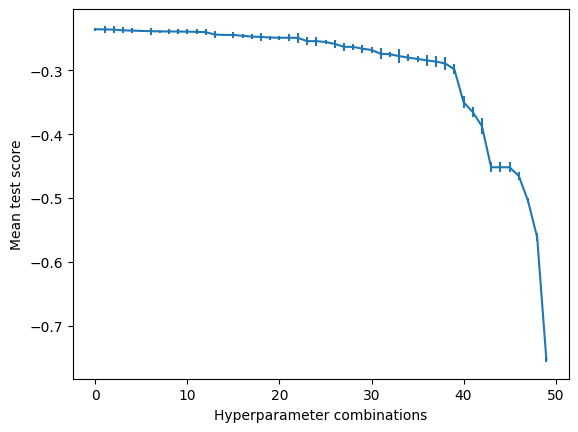

In [ ]:
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
results.reset_index(drop=True, inplace=True)
results['mean_test_score'].plot(yerr=[results['std_test_score'], results['std_test_score']], subplots=True)

plt.ylabel('Mean test score')
plt.xlabel('Hyperparameter combinations')

In [ ]:
X_train_preds = search.predict(X_train)
X_test_preds = search.predict(X_test)

print('Train roc_auc: ', mean_squared_error(y_train, X_train_preds))
print('Test roc_auc: ', mean_squared_error(y_test, X_test_preds))

Train roc_auc:  0.15191739746211158
Test roc_auc:  0.22089645891212886
